<a href="https://colab.research.google.com/github/NoahLee99/ML-DL-studylog/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* **생성적 적대 신경망(Generative Adversarial Networks, GAN)**은
<br> 딥러닝의 원리를 이용해 가상 이미지를 생성하는 알고리즘이다.

* 알고리즘 이름에 "적대적"이란 단어가 들어가 있는데,
<br> 이는 진짜 같은 가짜를 만들기 위해 GAN 알고리즘의
<br> 내부에서 "적대적" 경합을 진행하기 때문이다.

* 한쪽은 가짜를 만들고(**생성자, Generator**),
<br> 한쪽은 진짜와 비교(판별자, **Discriminator**)하는 경합 과정을 이용하는 것이 GAN의 원리이다.

* 페이스북의 AI 연구 팀이 만들어 발표한
<br> **DCGAN(Deep Convolutional GAN)**은 CNN을 GAN에 적용한 알고리즘인데,
<br> 기존의 GAN을 크게 불안정성을 크게 보완해주었다.

* 이 DCGAN을 직접 만들고 그 원리를 알아 보자.

# 가짜 제조 공장, 생성자

* **생성자(generator)**는 가상의 이미지를 만들어 내는 공장이다.

* 처음에는 랜덤한 픽셀 값으로 채워진 가짜 이미지로 시작해서
<br> 판별자의 판별 결과에 따라 지속적으로 업데이트하며 원하는 이미지를 만들어 간다.

* DCGAN에 사용되는 CNN에는 앞서 배운 CNN과 조금 차이가 있다.

* 먼저 옵티마이저를 사용하는 최적화 과정이나 컴파일 과정이 없다는 것이다.
<br> 판별과 학습이 이곳 생성자에서 일어나는 것이 아니기 때문이다.

* 또한, 일부 매개변수를 삭제하는 풀링 과정이 없는 대신 패딩 과정이 포함된다.
<br> 입력 크기와 출력 크기를 똑같이 맞추기 위해서 패딩을 사용한다.
<br> 즉 판별자가 비교할 "진짜" 이미지와 똑같은 크기가 되어야 하기 때문이다.

* 케라스의 패딩 함수에서 **padding='same'** 매개변수를 통해
<br> 입력과 출력의 크기가 다를 경우 자동으로 크기를 확장해 주고,
<br> 확장된 공간에 0을 채워 넣을 수 있다.
<br> 이렇게 패딩을 이용하면 커널을 거친 후에도 차원의 변동이 없게 만들 수 있다.

* DCGAN 알고리즘 개발자들은 학습에 꼭 필요한 옵션을 제시했는데,
<br> 그중 하나가 **배치 정규화(Batch Normalization)**라는 과정이다.

* 배치 정규화란 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것인데,
<br> 다음 층으로 입력될 값을 일정하게 재배치하는 역할을 한다.
<br> 이 과정을 통해 층의 개수가 늘어나도 안정적인 학습을 진행 가능하다.
<br> 케라스는 이를 위해 **BatchNormalization()** 함수를 제공한다.

* 또한, 생성자의 활성화 함수로 **ReLU()** 함수를 쓰고,
<br> 판별자로 넘겨주기 직전에는 **tanh()** 함수를 쓴다.
<br> tanh() 함수를 쓰면 출력되는 값을 -1 ~ 1 사이로 맞출 수 있다.
<br> 판별자에 입력된 이미지의 픽셀 범위도 -1 ~ 1로 맞추면
<br> 판별 조건이 모두 갖추어진다.

* MNIST 손글씨 이미지를 이용해 DCGAN 모델을 만들어 보자.

In [ ]:
# 필요 라이브러리 호출
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 다운로드
import os
if not os.path.exists("./data/gan_images"):
  os.makedirs("./data/gan_images")

In [ ]:
# 생성자 모델 설정
generator = Sequential() # 모델 이름을 generator로 지정

generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # input_dim은 100차원 크기의 벡터
generator.add(BatchNormalization()) # 데이터의 배치를 정규 분포로 만들음
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same')) # 모자란 부분을 자동으로 0으로 채움
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

* MNIST 손글씨 이미지 크기는 28 x 28인데, 왜 7 x 7 크기의 이미지를 넣었는가?

* **UpSampling2D()** 함수는 이미지의 가로세로 크기를 두 배 늘려주기에, 레이어를 지나서 최종적으로 28 x 28 크기가 된다.

* 이렇게 작은 크기의 이미지를 점점 늘려 가면서 컨볼루션 층을 지나치게 하는 것이 DCGAN의 특징이다.

* 케라스는 Upsampling과 Conv2D를 합친 **Conv2DTranspose()** 함수도 제공한다.

* **Reshape()** 함수를 통해 밀집층의 출력을 컨볼루션 층에 입력하기 위해 3차원 배열로 변환하였다. (1차원 --> 3차원)

* 컨볼루션 층의 **kernel_size=5**는 5 x 5크기의 커널을 의미한다.

* **LeakyReLU()** 함수는 ReLU() 함수에서 x 값이 음수이면
<br> 무조건 0이 되어 뉴런들이 일찍 소실되는 단점을 보완하기 위해,
<br> 0 이하에서도 작은 값을 갖게 만드는 활성화 함수이다.
<br> EX. LeakyReLU(0.2) == 0보다 작을 경우 0.2를 곱하라는 의미

# 진위를 가려내는 장치, 판별자

* **판별자(discriminator)**는 생성자에서 넘어온 이미지가 가짜인지 진짜인지를 판별해 주는 장치이다.

* 판별자의 모델은 컨볼루션 신경망의 구조를 그대로 가지고 와서 만들면 된다.

* 진짜 혹은 가짜만을 판별하므로 이진 로스 함수(binary_crossentropy)를 사용한다.

* 주의할 점으로, 판별자는 판별만 해줄 뿐, 자기 자신이 학습을 해서는 안된다!
<br> 판별자가 얻은 가중치는 생성자로 그대로 넘겨주어 생성자가 업데이트된 이미지를 만들도록 해야 한다.
<br> 따라서 판별자를 만들 때는 가중치를 저장하는 학습 기능을 꺼주어야 한다.

In [ ]:
# 판별자 모델 설정
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # 학습 기능 끄기

* 컨볼루션 층의 노드 수는 각각 64개, 128개로 설정했다.

* **strides=2**라고 설정했다는 것은 커널 창을 두 칸씩 움직이겠다는 의미이다.

* 커널 창을 여러 칸 움직이게 하면, 가로세로 크기가 더 줄어들어 계산량이 감소하고 새로운 특징을 뽑아 주는 효과가 생긴다.

* 생성자에서는 출력 수를 28로 맞추어야 하기에 업샘플링을 통해 가로세로의 크기를 늘려 주었지만, 판별자는 진짜와 가짜만 구분하면 되기에 그럴 필요가 없다.

# 적대적 신경망 실행하기

* GAN의 기본 구조를 말로 설명하자면, 먼저 입력 값 input이 생성자 모델에 전달된다.

* 성성자 모델을 거쳐 출력된 input은 판별자 모델에 전달되고, 판별자는 "진짜" 데이터와 비교해 이진 분류를 진행한다.

* 하지만 학습이 진행될수록 생성자가 만든 input과 진짜 데이터가 너무나 비슷해져, 판별자가 진위를 구별하지 잘 못하게 된다.

* 이렇게 판별자의 정확도가 0.5에 가까워질 때,
<br> 비로소 생성자는 자신의 역할을 다하게 되어 학습이 종료된다.

In [ ]:
# GAN 모델 설정(생성자와 판별자 모델을 연결)
ginput = Input(shape=(100,)) # 생성자에 입력할 값
dis_output = discriminator(generator(ginput)) # 판별자가 진위를 판별한 결과 값
gan = Model(ginput, dis_output) # 생성자와 판별자 연결

gan.compile(loss='binary_crossentropy', optimizer='adam')

gan.summary()

Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 28, 28, 1)           │         865,281 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 1)                   │         212,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
epoch:0  d_loss:0.6730  g_loss:0.6667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
epoch:1  d_loss:0.6789  g_loss:0.6645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:2  d_loss:0.6805  g_loss:0.6607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
epoch:3  d_loss:0.6809  g_loss:0.6553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:4  d_loss:0.6809  g_loss:0.6527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:5  d_loss:0.6827  g_loss:0.6498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:6  d_loss:0.6850  g_loss:0.6466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:7  d_loss:0.6866  g_loss:0.6438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
epoch:8  d_loss:0.6872  g_loss:0.6404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
epoch:9  d_loss:0.6878  g_loss:0.6372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:10  d_loss:0.6879  g_loss:0.6347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
epoch:11  d_loss:0.6877  g_loss:0.6336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
epoch:12

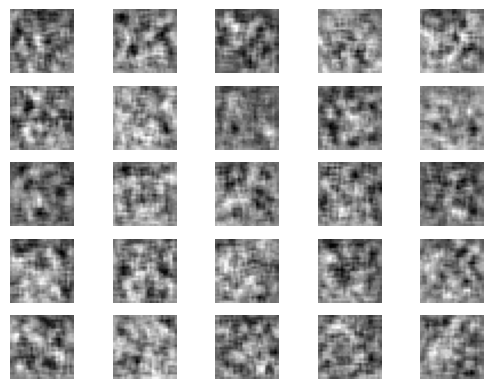

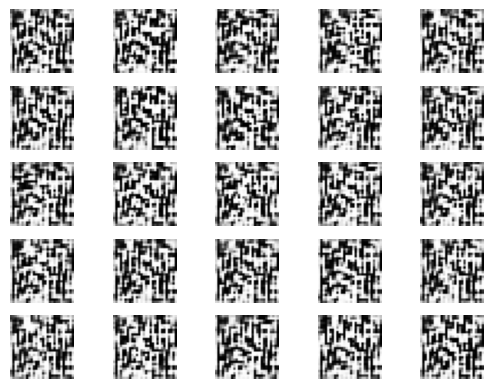

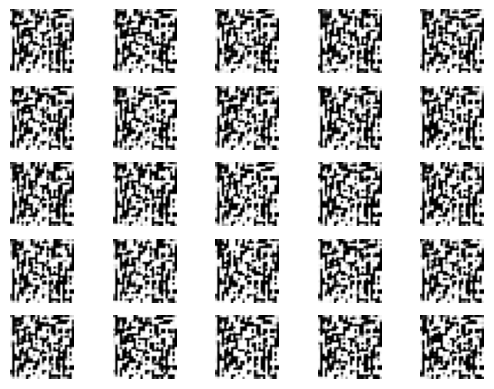

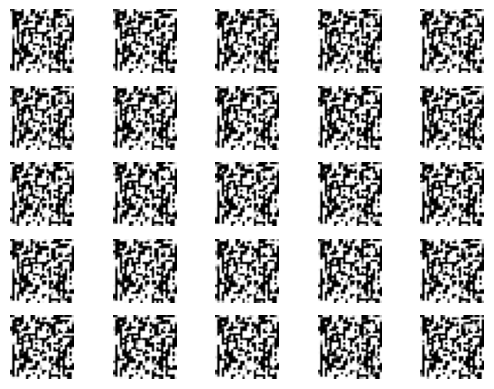

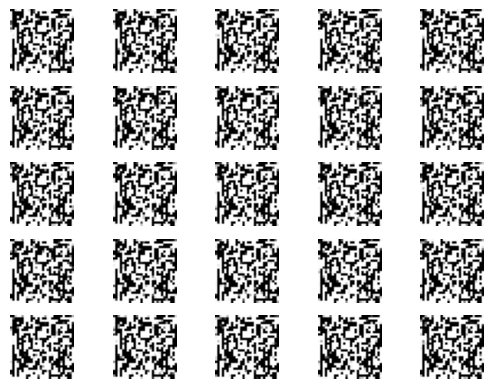

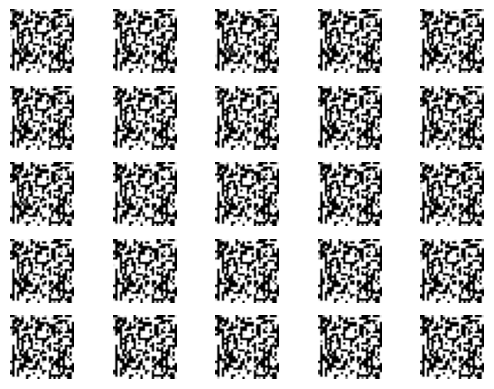

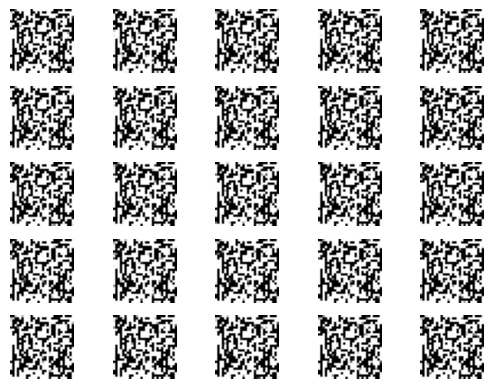

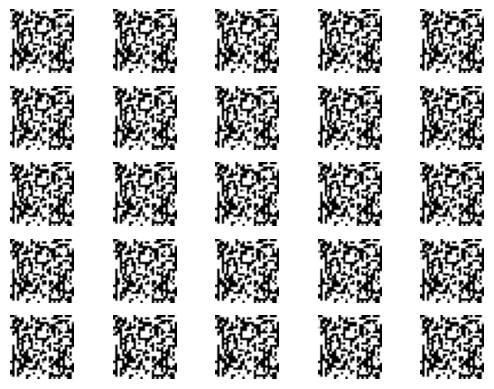

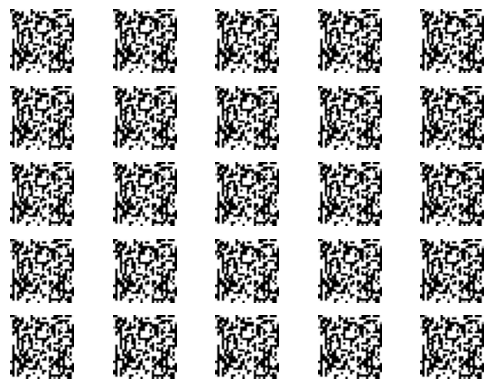

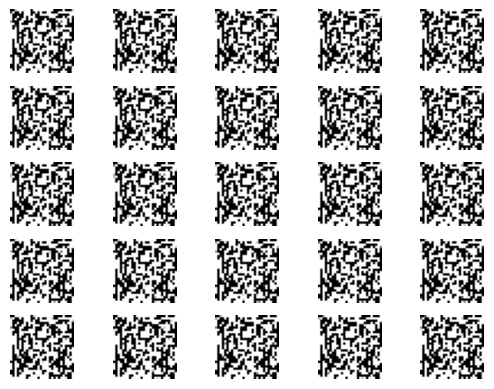

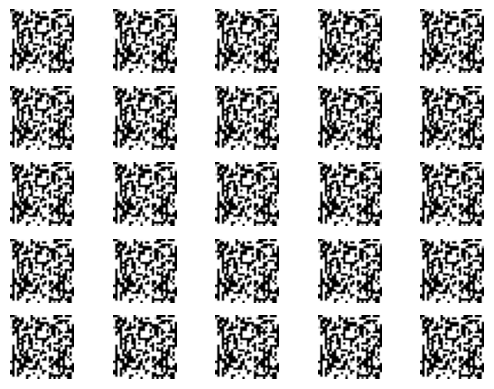

In [ ]:
# GAN 신경망을 실행할 함수 설정
def gan_train(epoch, batch_size, saving_interval): # 세 가지 변수 지정

# MNIST 데이터셋 로드
  (X_train, _), (_, _) = mnist.load_data() # 앞서 불러온 MNIST 데이터셋을 다시 이용, 단 테스트 과정 없이 이미지만 사용
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') # 28 x 28 크기의 흑백 이미지
  X_train = (X_train - 127.5) / 127.5 # tanh() 함수를 사용하므로 -1 ~ 1의 값이 되도록 계산

  # 판별자의 학습을 위한 레이블 생성
  true = np.ones((batch_size, 1)) # 진짜 == 1
  fake = np.zeros((batch_size, 1)) # 가짜 == 0

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분
            # 0 ~ 샘플 수까지 숫자(이미지) 중 하나를 랜덤하게 선택해 가져오는 과정을 batch_size만큼 반복
          idx = np.random.randint(0, X_train.shape[0], batch_size)


            # 선택된 숫자에 해당하는 이미지를 불러옴
          imgs = X_train[idx]

            # 판별을 시작
          d_loss_real = discriminator.train_on_batch(imgs, true)
            # train_on_batch() 함수는 입력 값(x)과 레이블(y)을 받아서 딱 한 번 학습을 실시해 모델을 업데이트함

          # 가상 이미지를 판별자에 입력하는 부분
            # 생성자에 집어넣을 가상 이미지 만들기
          noise = np.random.normal(0, 1, (batch_size, 100))
            # 정수가 아니기 때문에 np.random.normal() 함수를 사용, np.random.randint()와 작동 방식 동일함

            # 만들어진 가상 이미지가 생성자에 들어간 후 결과값을 저장
          gen_imgs = generator.predict(noise)

            # 판별을 시작
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            # 이제 d_loss_real과 d_loss_fake가 판별자 안에서 번갈아 가며 진위를 판단하기 시작함!

          # 판별자의 오차 계산
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          # d_loss_real, d_loss_fake 값을 더해 2로 나눈(* 0.5) 평균이 판별자의 오차 값

          # 생성자의 오차 계산
          g_loss = gan.train_on_batch(noise, true)
          # 생성자의 레이블은 무조건 참(1)이라 해놓고 판별자로 전달함

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이미지 분류 중간 과정 시각화
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./data/gan_images/gan_mnist_%d.png" % i)

# 2000번 반복되고 +1을 하는 것에 주의! (파이썬 range() 함수 특징)
# 배치 크기는 32, 200번마다 결과가 저장됨
gan_train(2001, 32, 200)

# 이미지의 특징을 추출하는 오토인코더

* 딥러닝을 이용해 가상의 이미지를 만드는 또 하나의 알고리즘인 **오토 인코더(Auto-Encoder, AE)**가 있다.

* 오토 인코더는 GAN과 비슷한 결과를 만들지만, 다른 성질을 지니고 있다.
<br> GAN이 세상에 존재하지 않는 완전한 가상의 것을 만들어 내는 반면에,
<br> 오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어 낸다.

* 오토인코더로 사람의 얼굴을 만들 경우 초점이 흐릿하고 윤곽이 불명확하지만 사람의 특징을 유추할 수 있는 것들이 모여 이미지가 만들어진다.

* 오토인코더의 구조는 입력한 이미지와 똑같은 크기로 출력층을 만든 뒤,
<br> 입력층보다 적은 수의 노드를 가진 은닉층을 중간에 넣어 차원을 줄인다.
<br> 이때 소실된 데이터를 복원하기 위해 학습을 시작하고,
<br> 이 과정을 통해 입력 데이터의 특징을 효율적으로 응축한 새로운 출력이 나오는 원리이다.

In [ ]:
from tensorflow.keras.layers import MaxPooling2D

# MNIST 데이터셋 로드
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델 설정
autoencoder = Sequential()

# 인코딩 부분 설정
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분 설정
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조 확인
autoencoder.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3395 - val_loss: 0.1402
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1352 - val_loss: 0.1210
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1202 - val_loss: 0.1128
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1128 - val_loss: 0.1075
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1081 - val_loss: 0.1043
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1049 - val_loss: 0.1015
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1025 - val_loss: 0.0996
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1006 - val_loss: 0.0980
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0991 - val_loss: 0.0969
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0979 - val_loss: 0.0960
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0967 - val_loss: 0.0949
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/ste

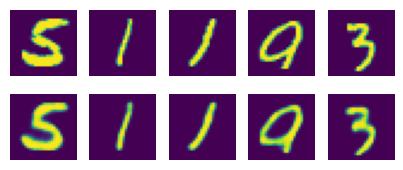

In [20]:
# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 모델 학습 실행
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과 출력
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옴.
ae_imgs = autoencoder.predict(X_test) # 앞서 만든 오토인코더 모델에 집어 넣음

# 출력 이미지 시각화
plt.figure(figsize=(7, 2)) # 출력될 이미지의 크기 설정

for i, image_idx in enumerate(random_test): # 랜덤하게 뽑은 이미지를 차례로 나열
   ax = plt.subplot(2, 7, i + 1)

   plt.imshow(X_test[image_idx].reshape(28, 28)) # 테스트할 이미지를 먼저 그대로 시현

   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)

   plt.imshow(ae_imgs[image_idx].reshape(28, 28)) # 오토인코딩 결과를 다음열에 출력
   ax.axis('off')
plt.show()